In [3]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np
import numpy.ma as ma

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

import scipy.optimize as opt
from scipy.stats import crystalball
from sklearn.metrics import roc_auc_score, roc_curve

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [4]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified


In [6]:
equal_dataset = "/hpc/group/vossenlab/mfm45/.dgl/mc__data_balanced_dataset_3_25_23"
equal_graphs = GraphDataset(equal_dataset)
equal_graphs.load()

In [25]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

#MC with same sig bg ratio as data
MCdataset = "mc__data_balanced_dataset_3_25_23"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
# MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [26]:
# MC_graphs = GraphDataset(equaldataset)
MC_graphs = GraphDataset(prefix + MCdataset)
DATA_graphs = GraphDataset(prefix + DATAdataset)

In [27]:
num_samples = 100
training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = num_samples, max_events = DATA_max_events)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = num_samples, max_events = MC_max_events)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = num_samples, max_events = DATA_max_events)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events)

val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "val",num_samples = num_samples, max_events = DATA_max_events)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [28]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(52)
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

In [29]:
num_epochs = 3

  0%|          | 0/1128 [02:34<?, ?it/s]


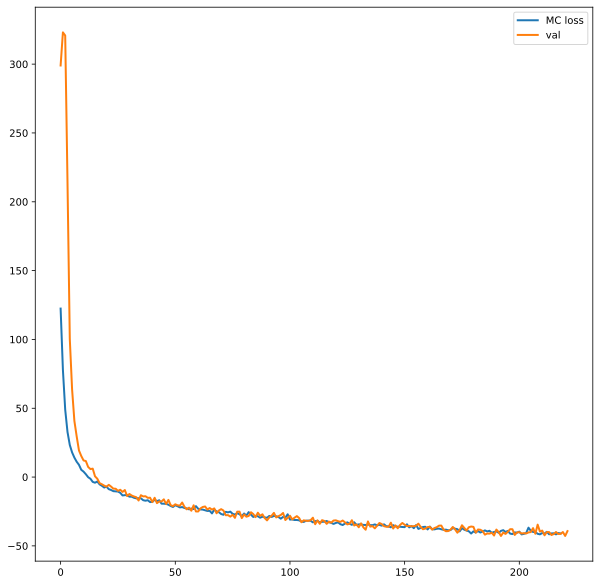

Lowest Loss: -41.64986019134521


In [30]:
# TRAINING MC
loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_MC, MC_model, val = True, val_data = val_data_MC, num_epochs = 4, compact_num = 20)
plot_loss(loss_hist, label = "MC loss",plot_val = True, val_loss_hist = val_hist)

In [31]:
# SETTING UP DATA MODEL

masked_affine_flows_train_DATA = get_masked_affine(50)
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)


  0%|          | 0/1992 [04:21<?, ?it/s]


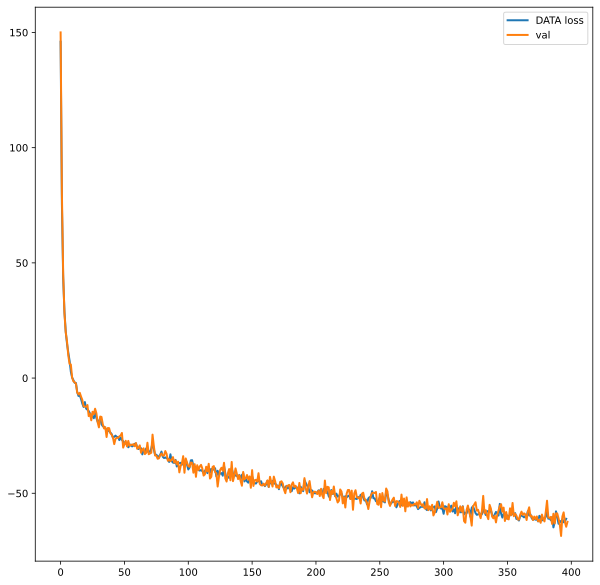

Lowest Loss: -64.79579734802246


In [32]:
# TRAINING DATA
loss_hist, val_hist, full_loss_hist, full_val_hist = train(training_data_DATA, DATA_model, val = True, val_data = val_data_DATA, num_epochs = 4, compact_num = 20)
plot_loss(loss_hist, label = "DATA loss", plot_val = True, val_loss_hist = val_hist)

In [33]:
# Testing MC
test(testing_data_MC, MC_model, data_type = "MC")
# Testing DATA
test(testing_data_DATA, DATA_model, data_type = "DATA")

100%|██████████| 141/141 [00:03<00:00, 42.67it/s]


MC average loss: -41.24964904785156


100%|██████████| 249/249 [00:05<00:00, 44.81it/s]

DATA average loss: -65.03271484375


In [34]:
transformed_latent_MC = transform(testing_data_MC, MC_model)
transformed_latent_DATA = transform(testing_data_DATA, DATA_model)

100%|██████████| 249/249 [00:05<00:00, 43.33it/s]


In [35]:
transformed_latent_train_MC = transform(training_data_MC, MC_model)
transformed_latent_train_DATA = transform(training_data_DATA, DATA_model)
transformed_latent_val_MC = transform(val_data_MC, MC_model)
transformed_latent_val_DATA = transform(val_data_DATA, DATA_model)

100%|██████████| 2075/2075 [00:41<00:00, 49.59it/s]


In [36]:
# From above plotting: <transformed_latent_DATA> is the tensor with normalized DATA
# Now need to transform it back to MC version of latent space
transformed_latent_DATA_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
transformed_latent_DATA_obj.set_batch_size(num_samples)
transformed_latent_MC_obj = Latent_data(transformed_latent_MC,testing_data_MC.labels)
transformed_latent_MC_obj.set_batch_size(num_samples)

In [37]:
transformed_latent_train_DATA_obj = Latent_data(transformed_latent_train_DATA,training_data_DATA.labels)
transformed_latent_train_DATA_obj.set_batch_size(num_samples)
transformed_latent_train_MC_obj = Latent_data(transformed_latent_train_MC,training_data_MC.labels)
transformed_latent_train_MC_obj.set_batch_size(num_samples)

In [38]:
transformed_latent_val_DATA_obj = Latent_data(transformed_latent_val_DATA,val_data_DATA.labels)
transformed_latent_val_MC_obj = Latent_data(transformed_latent_val_MC,val_data_MC.labels)

In [39]:
full_pass_DATA = transform(transformed_latent_train_DATA_obj, MC_model, reverse = False)
full_pass_DATA_obj = Latent_data(full_pass_DATA, training_data_DATA.labels)
full_pass_DATA_obj.set_batch_size(num_samples)

100%|██████████| 1992/1992 [00:44<00:00, 45.11it/s]


## Prediction

In [48]:
classifier = NFClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs = 4

  0%|          | 0/1128 [00:04<?, ?it/s]


Finished Training


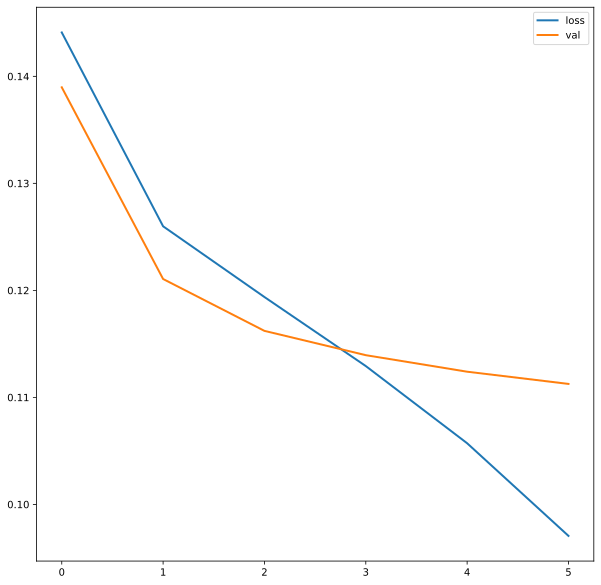

Lowest Loss: 0.09705412181107499


In [49]:
loss_hist, val_loss_hist = train_classifier(transformed_latent_train_MC_obj, classifier, criterion, optimizer, val = True, val_data = transformed_latent_val_MC_obj, num_epochs = 6)

plot_loss(loss_hist, plot_val =True, val_loss_hist = val_loss_hist)

In [52]:
test_classifier_MC(transformed_latent_val_MC_obj,classifier)

  0%|          | 0/1176 [00:00<?, ?it/s]


Accuracy: 96.66950113378685


## Normalized data classification

In [53]:
DATA_labels = test_classifier_data(transformed_latent_train_DATA_obj, classifier)

  0%|          | 0/1992 [00:07<?, ?it/s]


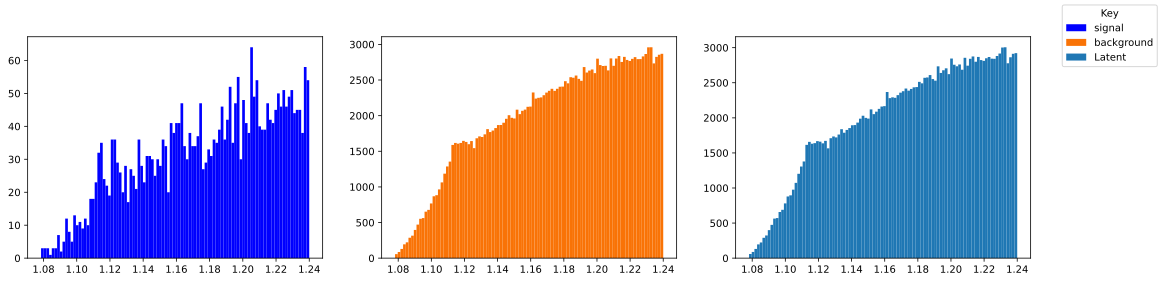

In [54]:
plot_classified(training_data_DATA.mass, DATA_labels, label = "Latent")

In [55]:
def test_classifier_data_DEBUG(test_data, classifier):
    outputs_data = torch.empty(test_data.num_events,2)
    #Converting normalized DATA to classifier output
    with tqdm(total=test_data.max_iter, position=0, leave=True) as pbar:
        for it in tqdm(range(test_data.max_iter), position = 0, leave=True):
            #randomly sample the latent space
            samples, labels = test_data.sample(iteration = it, _give_labels = True)
            samples = samples.to(device)
            # forward + backward + optimize
            output_batch = classifier(samples)
            for i in range(test_data.batch_size):
                outputs_data[it*test_data.batch_size + i] = output_batch[i]
    probs_data = torch.softmax(outputs_data, 1)
    return probs_data

In [94]:
probs_DATA_norm = test_classifier_data_DEBUG(transformed_latent_train_DATA_obj, classifier)
probs_MC_norm = test_classifier_data_DEBUG(transformed_latent_train_MC_obj, classifier)

  0%|          | 0/1128 [00:04<?, ?it/s]


##### Plotting output probability histogram

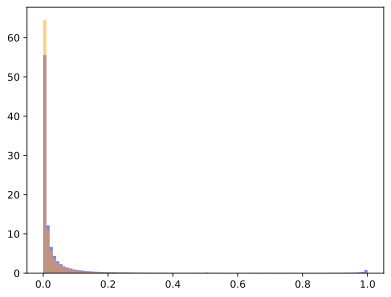

In [78]:
plt.hist(probs_MC_norm[:,1].detach().to("cpu"),color = "blue", alpha = 0.5, label = "MC", bins = 100,density = True);
plt.hist(probs_DATA_norm[:,1].detach().to("cpu"), color = "orange", alpha = 0.5, label= "Data", bins = 100,density = True);
plt.show()

AUC = 0.9406


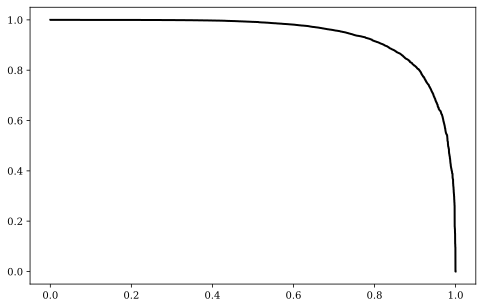

In [91]:
# Get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(training_data_MC.labels.detach().to("cpu").numpy(), probs_MC_norm[:,1].detach().to("cpu").numpy())

# Get area under the ROC curve

auc = roc_auc_score(np.squeeze(training_data_MC.labels.detach().to("cpu").numpy()), probs_MC_norm[:,1].detach().to("cpu").numpy())
print(f'AUC = {auc:.4f}')

# Create matplotlib plots for ROC curve and testing decisions
f = plt.figure(figsize=(8,5))

# Get some nicer plot settings 
# plt.rcParams['figure.figsize'] = (4,4)#DEBUGGING
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# Plot the ROC curve
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black')

roc_cut = 0.3
FOM = 5.237635394003901




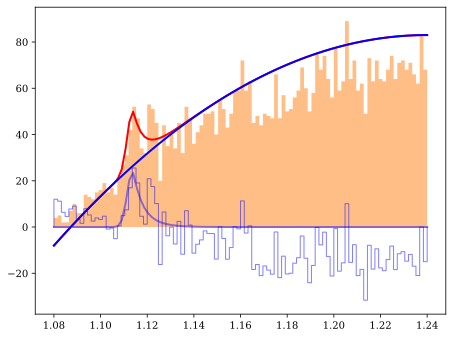

In [125]:
roc_cut = 0.3
probs_data = probs_DATA_norm

argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_DATA_norm[:,1]],dtype=torch.long)

signal_mass = argmax_Y * training_data_DATA.mass

# Define fit function


low_high = (1.08,1.24)
bins = 100

hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.max(hdata[0][-10:-1]), 37, 1.24
d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

def func(x, N, beta, m, loc, scale, B, A=A, C=C):
    return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

def sig(x, N, beta, m, loc, scale):
    return N*crystalball.pdf(-x, beta, m, -loc, scale)

def bg(x, B, A=A, C=C):
    return A*(1 - B*(x - C)**2)

optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))

x = np.linspace(low_high[0],low_high[1],bins)
y = hdata[0]

plt.plot(x, func(x, *optParams), color='r')
plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
plt.plot(x, bg(x, *optParams[5:]), color='b')

bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b')
plt.savefig("plots/bghist_0_07_diff.jpeg")

r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
chi2 = np.sum(np.square(r))
chi2ndf = chi2/len(optParams)

# Get S and N before and after? #DEBUGGING: ADDED
import scipy.integrate as integrate
mu      = optParams[3]
sigma   = optParams[4]
mmin    = mu - 2*sigma
mmax    = mu + 2*sigma


binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

bin1 = int((mmin-low_high[0])/binwidth)
bin2 = int((mmax-low_high[0])/binwidth)

integral_bghist = sum(bghist[0][bin1:bin2])

integral_tothist = sum(hdata[0][bin1:bin2])

fom = integral_bghist/np.sqrt(integral_tothist)
print(f"roc_cut = {roc_cut}\nFOM = {(integral_bghist)/np.sqrt(integral_tothist)}\n\n")

## Normalized FOM
1. roc_cut: 0: FOM 29.3
2. roc_cut: 0.13: FOM 28.3
3. roc_cut: 0.22: FOM 27.19
4. roc_cut: 0.35: FOM

In [113]:
float(MC_graphs.labels[:,0].sum() / len(MC_graphs.labels[:,0])) * 100

4.544832987332645

In [115]:
argmax = torch.max(probs_DATA_norm, 1)[1].view(-1, 1)

In [118]:
argmax.sum() / len(argmax)

tensor(0.0160)